#### 목표 : 생선 품종 분류 모델
- 데이터 : fish.csv
- 피쳐 : Weight, Length
- 타겟 : Species
- 기계학습 : 지도학습 + 분류 (도미, 빙어 분류는 이진분류)

(1) 모듈 준비 및 데이터 준비

In [48]:
# 데이터분석 모듈 로딩
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

In [49]:
# 데이터 파일 설정
data_file = '../data/fish.csv'

In [50]:
# DF로 데이터 준비
fishDF = pd.read_csv(data_file, usecols=[0,1,2])

# 기본정보 확인
fishDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Species  159 non-null    object 
 1   Weight   159 non-null    float64
 2   Length   159 non-null    float64
dtypes: float64(2), object(1)
memory usage: 3.9+ KB


(2) 데이터 전처리
- 결측치, 중복데이터, 이상치

In [51]:
# 컬럼별 고유값으로 이상치 체크 => unique()
print('fishDF.Species => ', fishDF.Species.unique())
print('fishDF.Weight => ', fishDF.Weight.unique())
print('fishDF.Length => ', fishDF.Length.unique())

fishDF.Species =>  ['Bream' 'Roach' 'Whitefish' 'Parkki' 'Perch' 'Pike' 'Smelt']
fishDF.Weight =>  [ 242.   290.   340.   363.   430.   450.   500.   390.   475.   600.
  700.   610.   650.   575.   685.   620.   680.   725.   720.   714.
  850.  1000.   920.   955.   925.   975.   950.    40.    69.    78.
   87.   120.     0.   110.   150.   145.   160.   140.   169.   161.
  200.   180.   272.   270.   306.   540.   800.    55.    60.    90.
  170.   273.   300.     5.9   32.    51.5   70.   100.    80.    85.
  115.   125.   130.   135.   225.   188.   197.   218.   260.   265.
  250.   320.   514.   556.   840.   690.   900.   820.  1015.  1100.
  345.   456.   510.   567.   770.  1250.  1600.  1550.  1650.     6.7
    7.5    7.     9.7    9.8    8.7   10.     9.9   12.2   13.4   19.7
   19.9]
fishDF.Length =>  [25.4 26.3 26.5 29.  29.7 30.  30.7 31.  31.5 32.  33.  33.5 34.  34.5
 35.  36.  37.  38.5 39.5 41.  14.1 18.2 18.8 19.8 20.  20.5 20.8 21.
 22.  22.5 24.  23.4 23.5 25.2 

In [52]:
# 결측치 체크 => isna() / isnull()
fishDF.isna().sum()

Species    0
Weight     0
Length     0
dtype: int64

In [53]:
# 중복데이터 => duplicated()
fishDF.duplicated().sum()

4

In [54]:
# 'Bream', 'Smelt' 두가지 품종 데이터만 추출
BreamSmeltDF = fishDF[fishDF['Species'].isin(['Bream', 'Smelt'])]
BreamSmeltDF

# 인덱스 리셋 : 기존에 인덱스 삭제 후 0-base 인덱스 설정
# Scikit-learn에 저장 시 ndarray 타입으로 저장되면서 인덱스 정리
BreamSmeltDF = BreamSmeltDF.reset_index(drop=True)

# 기본 정보 확인
BreamSmeltDF.info()

# 인덱스 확인
print(BreamSmeltDF.head(3), BreamSmeltDF.tail(3))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Species  49 non-null     object 
 1   Weight   49 non-null     float64
 2   Length   49 non-null     float64
dtypes: float64(2), object(1)
memory usage: 1.3+ KB
  Species  Weight  Length
0   Bream   242.0    25.4
1   Bream   290.0    26.3
2   Bream   340.0    26.5    Species  Weight  Length
46   Smelt    12.2    13.0
47   Smelt    19.7    14.3
48   Smelt    19.9    15.0


(3) 학습용 데이터 준비 => 피쳐 + 타겟 분리

In [55]:
# 피쳐 데이터 추출
feature = BreamSmeltDF[BreamSmeltDF.columns[1:]]
feature.head()

,Weight,Length
0,242.0,25.4
1,290.0,26.3
2,340.0,26.5
3,363.0,29.0
4,430.0,29.0


In [56]:
# 타겟 데이터 추출
target = BreamSmeltDF.Species
target.head()

0    Bream
1    Bream
2    Bream
3    Bream
4    Bream
Name: Species, dtype: object

In [57]:
# Bream => 0, Smelt => 1로 값 변환
target = target.replace({'Bream':0, 'Smelt':1}).copy()
target

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
30    0
31    0
32    0
33    0
34    0
35    1
36    1
37    1
38    1
39    1
40    1
41    1
42    1
43    1
44    1
45    1
46    1
47    1
48    1
Name: Species, dtype: int64

(4) 학습 진행
- 알고리즘 구현 인스턴스 생성 => 지도학습 -분류 알고리즘 중 선택 : KNN

- 학습 진행 메소드 => fit()

In [58]:
# (4-1) 
model = KNeighborsClassifier()

In [59]:
# (4-2) 학습 진행 fit(2D, 1D)
model.fit(feature, target)

KNeighborsClassifier()

In [60]:
# 학습 후 속성 확인 => 속성명_ : 모델 파라미터 -> 모델 학습 후 생성 및 저장됨!
print('class+ : ', model.classes_)
print('feature_names_in : ', model.feature_names_in_)
print('n_features_in_ : ', model.n_features_in_)

class+ :  [0 1]
feature_names_in :  ['Weight' 'Length']
n_features_in_ :  2


(5) 학습 후 검사 즉 테스트 => 메서드 : score()
- 결과값 : 0.0(0%) ~ 1.0(100%)
- 사용 데이터 : 학습에 사용되지 않은 데이터

In [61]:
model.score(feature, target)

1.0

(6) 예측 즉 서비스에 모델 활용시 사용 => 메소드 : predict()
- 조건 : 학습 시 전달된 데이터와 동일한 형태의 데이터 전달

In [62]:
# [무게, 길이]
new_dat = pd.DataFrame([[21.8, 17], [18.5, 15], [12.3, 6]], columns=model.feature_names_in_)

# 학습 시 제공된 데이터와 동일한 형태로 제공
pred_y = model.predict(new_dat)
pred_y

array([1, 1, 1], dtype=int64)

In [63]:
# 데이터와 최근접 이웃 데이터 찾기 => kneighbors() 메소드
# 반환값 : 거리, 원소번호
model.kneighbors(new_dat)

(array([[ 2.75862284,  3.42052628,  9.57705592, 10.4       , 10.73312629],
        [ 1.3892444 ,  1.4       ,  5.72450871,  6.60984115,  6.89420046],
        [ 5.63560112,  5.76974869,  6.2008064 ,  6.239391  ,  6.27694193]]),
 array([[48, 47, 45, 46, 44],
        [47, 48, 45, 46, 44],
        [38, 39, 44, 41, 42]], dtype=int64))

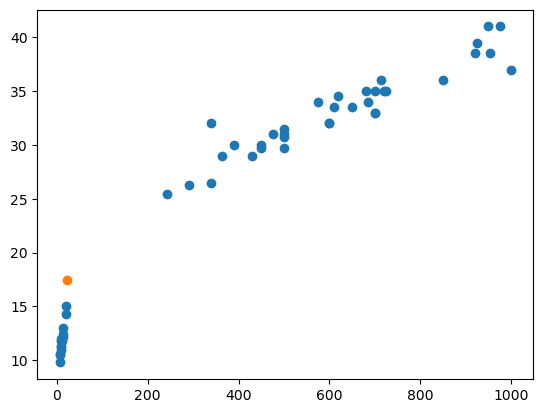

In [64]:
# Weight & Length 시각화
plt.scatter(BreamSmeltDF['Weight'], BreamSmeltDF['Length'])
plt.scatter(21.8, 17.5)
plt.show()

In [67]:
# feature.Weight, feature.Length

<Axes: xlabel='Weight', ylabel='Length'>

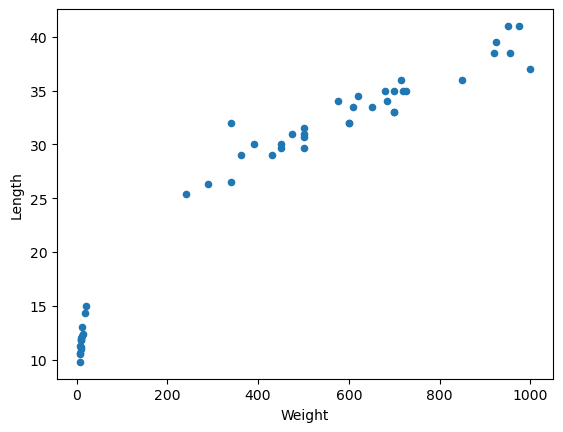

In [65]:
# pandas 활용
feature.plot(kind='scatter', x='Weight', y='Length')

In [70]:
dis, ind = model.kneighbors(new_dat)
ind.tolist()[0]

[48, 47, 45, 46, 44]

RangeIndex(start=0, stop=49, step=1)

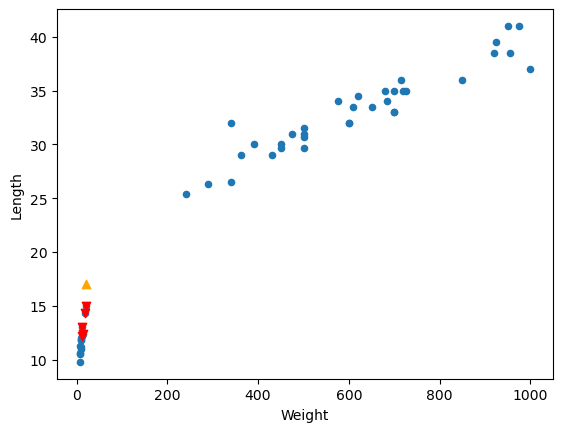

In [81]:
feature.plot(kind='scatter', x='Weight', y='Length')
plt.scatter(21.8, 17, color='orange', marker='^')
plt.scatter(feature.iloc[ind.tolist()[0]]['Weight'], feature.iloc[ind.tolist()[0]]['Length'], 
            color='red', marker='v')
plt.show()